## Récupération données WB

### Data

In [46]:
import pandas as pd
import numpy as np

Paramètres : 

In [47]:
first_year = 2004

country_list=["BEN","BFA"] #["BEN","BFA","CAN","CHE","DEU","HTI","MLI","NOR","SEN"]
indic_list=["PV.EST","GE.EST"] #["PV.EST","GE.EST","IQ.CPA.FINQ.XQ","IQ.CPA.DEBT.XQ"]

Processing :

In [50]:

df = pd.read_csv('data/raw_data.csv')


selected_countries = df.loc[df['Country Code'].isin(country_list)]
selected_countries_indicators = selected_countries.loc[selected_countries['Indicator Code'].isin(indic_list)]

selected_countries_indicators = selected_countries_indicators.drop(['Country Name','Indicator Name'], axis=1)

selected_countries_indicators = selected_countries_indicators.drop(selected_countries_indicators.columns[-1], axis=1)

df_melted = pd.melt(selected_countries_indicators, id_vars=['Country Code',"Indicator Code"], var_name='Date', value_name="Value")

contries_date_indic = df_melted.pivot(index=['Country Code', 'Date'], columns='Indicator Code', values='Value').reset_index()

contries_date_indic['Date'] = pd.to_numeric(contries_date_indic['Date'])
contries_date_indic = contries_date_indic[contries_date_indic['Date'] > first_year]

contries_date_indic.columns.name = None

contries_date_indic = contries_date_indic.drop(['Country Code','Date'], axis=1)

data=contries_date_indic.to_numpy()
data



array([[-0.6529879 ,  0.44974628],
       [-0.64701253,  0.54789257],
       [-0.54374969,  0.38621762],
       [-0.49289379,  0.37642136],
       [-0.59506071,  0.40366668],
       [-0.60990387,  0.26126012],
       [-0.54713935,  0.31835636],
       [-0.52674651,  0.3643676 ],
       [-0.50852346,  0.30118936],
       [-0.48498344,  0.02713976],
       [-0.68148828, -0.02049642],
       [-0.62491918, -0.0087835 ],
       [-0.69779992,  0.02625189],
       [-0.63140035, -0.14707476],
       [-0.49051583, -0.42025951],
       [-0.29078072, -0.44308379],
       [-0.23767088, -0.39634779],
       [-0.164296  , -0.34946138],
       [-0.60489899, -0.06265292],
       [-0.80056357,  0.15579955],
       [-0.77000624,  0.30700868],
       [-0.53028399,  0.1187246 ],
       [-0.61746973,  0.03404029],
       [-0.58909571, -0.11763714],
       [-0.56824374, -0.55538148],
       [-0.63236839, -0.57312924],
       [-0.6691156 , -0.76339012],
       [-0.59144777, -0.78712857],
       [-0.69087619,

### Target: using the CPIA debt policy rating (10=low to 60=high), _IQ.CPA.DEBT.XQ_

In [59]:
target="IQ.CPA.DEBT.XQ"


selected_countries_indicators = selected_countries.loc[selected_countries['Indicator Code']==target]
selected_countries_indicators = selected_countries_indicators.drop(['Country Name','Indicator Name'], axis=1)
selected_countries_indicators = selected_countries_indicators.drop(selected_countries_indicators.columns[-1], axis=1)
df_melted = pd.melt(selected_countries_indicators, id_vars=['Country Code',"Indicator Code"], var_name='Date', value_name="Value")
df_target = df_melted.pivot(index=['Country Code', 'Date'], columns='Indicator Code', values='Value').reset_index()
df_target['Date'] = pd.to_numeric(df_target['Date'])
df_target = df_target[df_target['Date'] > first_year]
df_target.columns.name = None
df_target = df_target.drop(['Country Code','Date'], axis=1)

target = (df_target.values * 10).ravel().astype(int)
target

array([35, 35, 35, 35, 35, 35, 35, 40, 40, 40, 40, 40, 40, 40, 45, 45, 45,
       45, 45, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
       40, 40])

Exemple :

In [66]:
import matplotlib.pyplot as plt

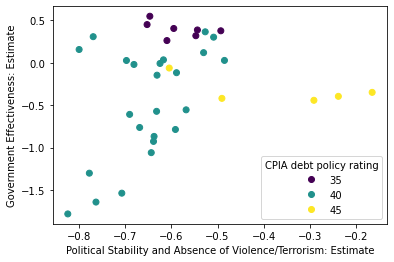

In [67]:
_, ax = plt.subplots()
scatter = ax.scatter(data[:, 0], data[:, 1], c=target)
ax.set(xlabel="Political Stability and Absence of Violence/Terrorism: Estimate", ylabel="Government Effectiveness: Estimate")
_ = ax.legend(scatter.legend_elements()[0], [35,40,45], loc="lower right", title="CPIA debt policy rating")
plt.show()

## First approach of decision tree with SK

In [68]:
#Importation des modules nécessaires
import sklearn
from sklearn.tree import DecisionTreeClassifier, plot_tree


In [69]:
#Déclaration de l'arbre de décision
clf = DecisionTreeClassifier(max_depth=3)

#Entrainement de l'abre de décision 
clf.fit(data, target)




DecisionTreeClassifier(max_depth=3)

[Text(0.625, 0.875, 'X[1] <= 0.37\ngini = 0.498\nsamples = 36\nvalue = [7, 24, 5]'),
 Text(0.5, 0.625, 'X[0] <= -0.5\ngini = 0.37\nsamples = 31\nvalue = [2, 24, 5]'),
 Text(0.25, 0.375, 'X[1] <= 0.209\ngini = 0.21\nsamples = 26\nvalue = [2, 23, 1]'),
 Text(0.125, 0.125, 'gini = 0.091\nsamples = 21\nvalue = [0, 20, 1]'),
 Text(0.375, 0.125, 'gini = 0.48\nsamples = 5\nvalue = [2, 3, 0]'),
 Text(0.75, 0.375, 'X[1] <= -0.161\ngini = 0.32\nsamples = 5\nvalue = [0, 1, 4]'),
 Text(0.625, 0.125, 'gini = 0.0\nsamples = 4\nvalue = [0, 0, 4]'),
 Text(0.875, 0.125, 'gini = 0.0\nsamples = 1\nvalue = [0, 1, 0]'),
 Text(0.75, 0.625, 'gini = 0.0\nsamples = 5\nvalue = [5, 0, 0]')]

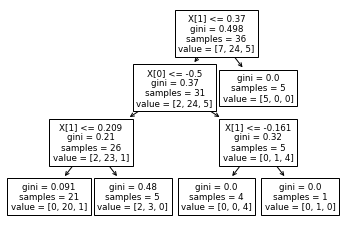

In [71]:
plot_tree(clf)


In [ ]:
dot_data = export_graphviz(clf, out_file=None, feature_names=iris.feature_names, class_names=iris.target_names, filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)  